In [12]:
# import necessary modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



In [13]:
# download Titanic dataset
# use train.csv as whole dataset(train and test)
data = pd.read_csv("./titanic/train.csv")

# check what the dataset looks like
print(data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [14]:
# preprocessing
# drop PassengerID (bacause it's just a ID, which doesn't explain each passenger's feature)
# drop "Name" because it is string data that doesn't contribute to prediction without further processing 
# drop "Cabin" because it has many missing values and is difficult to impute
# drop 'Ticket' because it is just random numbers of tickets
data = data.drop(['PassengerId','Name','Cabin', 'Ticket'],axis=1)





In [15]:
# separate features and target variable
X = data.drop(columns=['Survived'])
Y = data['Survived']


In [16]:
# encode category values
catCols = ['Sex', 'Embarked']

# I serched how to use LabelEncoder on ChatGPT
le = LabelEncoder()
for col in catCols:
    X[col] = le.fit_transform(X[col])

In [17]:
# train_test_split
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)


In [18]:
# fill missing values in 'Age' with average value
mean_age = X_train['Age'].mean()
X_train['Age'] = X_train['Age'].fillna(mean_age)
X_test['Age'] = X_test['Age'].fillna(mean_age)



In [19]:
# construct model
models = {
    "decision tree classifier": DecisionTreeClassifier(random_state=seed),
    "random forest classifier": RandomForestClassifier(random_state=seed),
    "logistic regression": LogisticRegression(random_state=seed),
    "SVM":SVC(random_state=seed)
}

In [20]:
# add grid serch for hyper parameter tuning

k_vals = np.array([1,2,3,4,5,6,7])
depths = np.array([1,2,3,4,5,6,7,8,9,10,None])

for model_name, model in models.items():
    print(model_name)
    if model_name in ["logistic regression","SVM"]:
        pipeline = Pipeline([
            ('select', SelectKBest(score_func=chi2)),
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        param_grid = {
            'select__k' : k_vals
        }
    else:
        pipeline = Pipeline([
            ('select', SelectKBest(score_func=chi2)),
            ('classifier', model)
        ])
        
        param_grid = {
            'select__k' : k_vals,
            'classifier__max_depth' : depths
        }
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)
    grid.fit(X_train,Y_train)

    print("Best score", grid.best_score_)
    print("Best params:", grid.best_params_)

decision tree classifier
Best score 0.837310924369748
Best params: {'classifier__max_depth': 3, 'select__k': 7}
random forest classifier
Best score 0.8473949579831933
Best params: {'classifier__max_depth': 7, 'select__k': 5}
logistic regression
Best score 0.8121288515406162
Best params: {'select__k': 6}
SVM
Best score 0.8507002801120448
Best params: {'select__k': 7}


In [21]:
# redifine models with best parameters (max_depth for tree based models)
models = {
    "decision tree classifier": DecisionTreeClassifier(random_state=seed,max_depth=3),
    "random forest classifier": RandomForestClassifier(random_state=seed, max_depth=7),
    "logistic regression": LogisticRegression(random_state=seed),
    "SVM":SVC(random_state=seed)
}

In [22]:
# Check feature importances for tree based models
# as a result of the code below. it seems like sex is the most important feature

for model_name, model in models.items():
    if model_name == "decision tree classifier" or model_name == "random forest classifier":
        print(f"model name : {model_name}")
        model.fit(X_train, Y_train)
        for feature, importance in zip(X_train.columns, model.feature_importances_):
            print(f"{feature} : {importance}")
        print("\n")

model name : decision tree classifier
Pclass : 0.15417532487400668
Sex : 0.6352472761102862
Age : 0.07512001441625905
SibSp : 0.06403652717770154
Parch : 0.0
Fare : 0.0714208574217465
Embarked : 0.0


model name : random forest classifier
Pclass : 0.10027997941357736
Sex : 0.3885839443460421
Age : 0.16578657605026337
SibSp : 0.05469468014062455
Parch : 0.05094329158500232
Fare : 0.1934365857145601
Embarked : 0.046274942749930305




In [23]:
# difine pipelines with best parameters

for model_name, model in models.items():
    print(model_name)
    if model_name == "decision tree classifier":
        pipeline = Pipeline([
            ('select', SelectKBest(score_func=chi2,k=7)),
            ('classifier', model)
        ])
    elif model_name == "random forest classifier":
        pipeline = Pipeline([
            ('select', SelectKBest(score_func=chi2, k=5)),
            ('classifier', model)
        ])
    elif model_name == "logistic regression":
            pipeline = Pipeline([
            ('select', SelectKBest(score_func=chi2,k=6)),
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
    elif model_name == "SVM":
        pipeline = Pipeline([
            ('select', SelectKBest(score_func=chi2,k=7)),
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])


    model.fit(X_train, Y_train)

    Y_pred = model.predict(X_test)
    cm = confusion_matrix(Y_test, Y_pred)
    report = classification_report(Y_test, Y_pred)

    print(f"confusion matrix \n {cm} \n")
    print(f"classification report \n {report}")

decision tree classifier
confusion matrix 
 [[154  22]
 [ 41  78]] 

classification report 
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       176
           1       0.78      0.66      0.71       119

    accuracy                           0.79       295
   macro avg       0.78      0.77      0.77       295
weighted avg       0.79      0.79      0.78       295

random forest classifier
confusion matrix 
 [[160  16]
 [ 45  74]] 

classification report 
               precision    recall  f1-score   support

           0       0.78      0.91      0.84       176
           1       0.82      0.62      0.71       119

    accuracy                           0.79       295
   macro avg       0.80      0.77      0.77       295
weighted avg       0.80      0.79      0.79       295

logistic regression
confusion matrix 
 [[148  28]
 [ 39  80]] 

classification report 
               precision    recall  f1-score   support

           0     

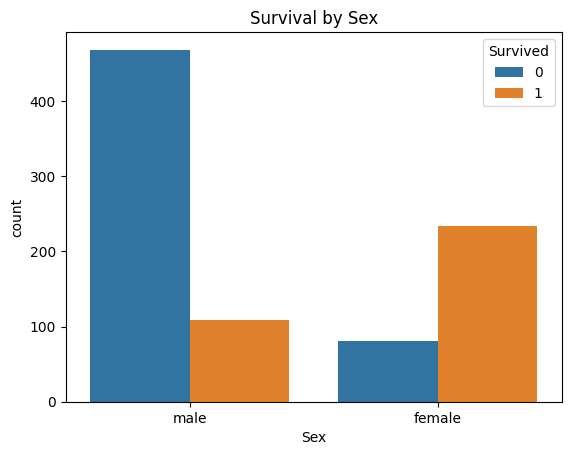

In [24]:
# visualize categirical bias
sns.countplot(data=data, x='Sex', hue='Survived')
plt.title("Survival by Sex")
plt.show()